### GLOBAL CONFIG

In [198]:
%load_ext autoreload
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle

PREPROCESS = False # Do a fresh preprocess
MAKE_NEW_EMBEDDING = True # If False, the stored one will be loaded
# EMB_MAX_WORDS = None
RANDOM_SEED = 456
SAVE_TRAINED_MODEL = True

PREPROCESS_INPUT = './data/training.1600000.processed.noemoticon.csv'
PREPROCESS_OUTPUT = './data/preprocessed.csv'
GLOVE_FILE = './data/glove.6B.50d.txt'
EMB_PKL = './models/emb_layer.pkl'
MODEL_PKL = './models/model.pkl'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preprocess data and store it

In [199]:
from pre import preprocess

if PREPROCESS:
    preprocess(i=PREPROCESS_INPUT, o=PREPROCESS_OUTPUT, slice=10)

### Load preprocessed data

In [200]:
from parse import load_data
from sklearn.model_selection import train_test_split

data = load_data(PREPROCESS_OUTPUT)
X = data['tweet']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_SEED)

y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)
y_val = tf.keras.utils.to_categorical(y_val, 2)


In [201]:
### Create Empty model
from TextClassifierModel import new_classifier, load_classifier




trained_model_path = 'models/trained'
untrained_model_path = 'models/untrained'

new_model = True
if new_model:
    text_classifier = new_classifier(glove_file = GLOVE_FILE, data=data)
else:
    text_classifier = load_classifier(model_path=untrained_model_path)
print(text_classifier.model.summary())


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 50)           142450    
_________________________________________________________________
flatten_28 (Flatten)         (None, 5000)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 5000)              0         
_________________________________________________________________
dense_70 (Dense)             (None, 64)                320064    
_________________________________________________________________
dense_71 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_72 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_73 (Dense)             (None, 2)               

### Train

Epoch 1/30
11/11 [==============================] - 1s 23ms/step - loss: 2.3326 - accuracy: 0.5156 - val_loss: 1.8627 - val_accuracy: 0.4062
Epoch 2/30
11/11 [==============================] - 0s 13ms/step - loss: 1.6089 - accuracy: 0.5625 - val_loss: 1.3926 - val_accuracy: 0.5437
Epoch 3/30
11/11 [==============================] - 0s 17ms/step - loss: 1.2724 - accuracy: 0.6187 - val_loss: 1.2016 - val_accuracy: 0.6125
Epoch 4/30
11/11 [==============================] - 0s 13ms/step - loss: 1.1003 - accuracy: 0.6625 - val_loss: 1.0965 - val_accuracy: 0.6000
Epoch 5/30
11/11 [==============================] - 0s 13ms/step - loss: 0.9605 - accuracy: 0.7078 - val_loss: 1.1299 - val_accuracy: 0.5500
Epoch 6/30
11/11 [==============================] - 0s 13ms/step - loss: 0.8572 - accuracy: 0.7391 - val_loss: 1.0829 - val_accuracy: 0.5562
Epoch 7/30
11/11 [==============================] - 0s 11ms/step - loss: 0.7616 - accuracy: 0.7859 - val_loss: 1.0324 - val_accuracy: 0.5813
Epoch 8/30
11

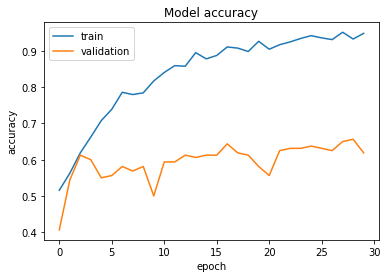

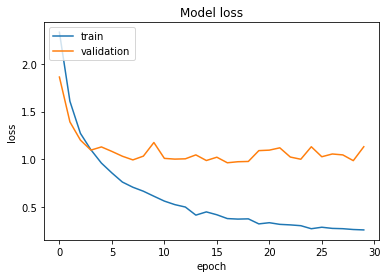

In [202]:
%autoreload 2
from evaluation import plot_history

history = text_classifier.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=60, epochs=30, verbose=1)
plot_history(history)


### Save trained model

In [203]:
from TextClassifierModel import save_classifier
save_classifier(text_classifier, 'models/trained')

INFO:tensorflow:Assets written to: models/trained/assets
classifiers/trained.pkl


### Evaluate production (forbidden during tuning)

In [204]:
from evaluation import evaluate_model

evaluate_model(text_classifier, X_test, y_test, verbose=False)

Accuracy 0.6549999713897705


### Explain prediction

In [205]:
import eli5
from eli5.lime import TextExplainer

te = TextExplainer(random_state=42)
te.fit("I love candy. I like to be positive, be happy! What a lovely day", text_classifier.predict_proba)
te.show_prediction()